In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 3

from sparcfuse.sparc_fuse_core import (list_primary_files,
                      download_and_convert_sparc_data)

DATASET_ID = 224

files, meta = list_primary_files(DATASET_ID)

print("primary files: ", [f["path"] for f in files])

# Case 1 – convert a single file
download_and_convert_sparc_data(
    DATASET_ID,
    descriptors_dir="../mapping_schemes",
    primary_paths=files[0]["path"].replace("files/", ""),
    output_dir="../output_single", 
    file_format="zarr"  # or "zarr.zip"
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
primary files:  ['files/primary/sub-ChAT-Male-Subject-1/20_1021.acq', 'files/primary/sub-ChAT-Male-Subject-2/20_1022.acq', 'files/primary/sub-ChAT-Female-Subject-1/20_1023.acq', 'files/primary/sub-ChAT-Male-Subject-3/20_1027a.acq', 'files/primary/sub-ChAT-Female-Subject-2/20_1027b.acq', 'files/primary/sub-ChAT-Female-Subject-3/20_1028.acq', 'files/primary/sub-nNOS-Male-Subject-1/20_1202a.acq', 'files/primary/sub-nNOS-Male-Subject-2/20_1202b.acq', 'files/primary/sub-nNOS-Male-Subject-3/20_1203a.acq', 'files/primary/sub-nNOS-Female-Subject-1/20_1203b.acq', 'files/primary/sub-nNOS-Female-Subject-2/20_1207.acq', 'files/primary/sub-nNOS-Female-Subject-3/20_1208.acq', 'files/primary/manifest.xlsx']
[WARN] Failed to load descriptor from ../mapping_schemes/mapping_scheme_400_adi.py: No module named 'adi._adi_cffi'
[WARN] Failed to load descriptor from ../mapping_schemes/mapping_scheme_378.py: No module name

Dataset 224: 100%|██████████| 1/1 [00:06<00:00,  6.04s/it]


[{'rel_path': 'primary/sub-ChAT-Male-Subject-1/20_1021.acq',
  'local_path': '/tmp/tmp506h46fl/20_1021.acq',
  'std_path': 'output_single/20_1021_std.zarr',
  'descriptor_id': 'acq_mapping_001',
  'mapping_score': 3,
  'status': 'ok',
  'error': None}]

In [6]:
import zarr, s3fs

# Adjust region if needed (your bucket is in eu-north-1)
fs = s3fs.S3FileSystem(anon=False, client_kwargs={"region_name": "eu-north-1"})
s3_store = zarr.storage.FSStore("s3://sparc-fuse-demo-ab-2025/20_1021_std.zarr", fs=fs)

# Consolidate metadata for faster remote traversal
zarr.consolidate_metadata(s3_store)
print("Consolidated metadata.")


NoCredentialsError: Unable to locate credentials

In [8]:
import os
os.environ["AWS_DEFAULT_REGION"] = "eu-north-1"

import s3fs
import zarr
import xarray as xr
import numpy as np

# Connect to S3 Zarr
fs = s3fs.S3FileSystem(anon=False, client_kwargs={"region_name": "eu-north-1"})
store = zarr.storage.FSStore("s3://sparc-fuse-demo-ab-2025/20_1021_std.zarr", fs=fs)

# Open (prefer consolidated metadata if available)
try:
    root = zarr.open_consolidated(store)
except Exception:
    root = zarr.open(store)

# Show structure
print("Zarr tree:")
root.tree()

# Inspect arrays
signals_arr = root["signals"]
time_arr = root["time"]
print("signals shape:", signals_arr.shape, "attrs:", signals_arr.attrs)
print("time shape:", time_arr.shape, "attrs:", time_arr.attrs)

# Load arrays (lazy until sliced)
signals = signals_arr[:]  # full read; can slice instead if large
time = time_arr[:]

# Heuristic: align dimensions
if signals.shape[1] == len(time):
    # signals: (channel, time)
    ds = xr.Dataset(
        {"signals": (("channel", "time"), signals)},
        coords={"time": ("time", time), "channel": ("channel", np.arange(signals.shape[0]))},
    )
elif signals.shape[0] == len(time):
    # signals: (time, channel)
    ds = xr.Dataset(
        {"signals": (("time", "channel"), signals)},
        coords={"time": ("time", time), "channel": ("channel", np.arange(signals.shape[1]))},
    )
else:
    # Unknown layout; wrap generically
    ds = xr.Dataset({"signals": (("dim0", "dim1"), signals)})

print("\nConstructed xarray Dataset:")
print(ds)

# Example lazy access: slice without pulling everything
if "time" in ds.dims:
    print("\nExample slice:", ds["signals"].isel(time=0))


NoCredentialsError: Unable to locate credentials

In [9]:
import os
import numpy as np
import xarray as xr
import s3fs
import zarr

os.environ.setdefault("AWS_DEFAULT_REGION", "eu-north-1")
fs = s3fs.S3FileSystem(anon=False, client_kwargs={"region_name": "eu-north-1"})

# Load raw SPARC-FUSE Zarr (as you did)
raw_store = zarr.storage.FSStore("s3://sparc-fuse-demo-ab-2025/20_1021_std.zarr", fs=fs)
try:
    root = zarr.open_consolidated(raw_store)
except Exception:
    root = zarr.open(raw_store)

signals = root["signals"][:]
time = root["time"][:]

# Build the Xarray Dataset
ds = xr.Dataset(
    {"signals": (("channel", "time"), signals)},
    coords={"time": ("time", time), "channel": ("channel", np.arange(signals.shape[0]))},
)

# Write out a self-describing Zarr store with consolidated metadata
out_path = "s3://sparc-fuse-demo-ab-2025/20_1021_std_xarray.zarr"
out_store = zarr.storage.FSStore(out_path, fs=fs)
ds.to_zarr(out_store, mode="w", consolidated=True)


NoCredentialsError: Unable to locate credentials

In [10]:
import xarray as xr
ds = xr.open_zarr("s3://sparc-fuse-demo-ab-2025/20_1021_std_xarray.zarr", consolidated=True)
print(ds)


NoCredentialsError: Unable to locate credentials

In [ ]:
# === Cloud-first preparation: convert a SPARC file, push to S3, consolidate, and emit an Xarray-compatible Zarr ===

import os
import subprocess
import json
import numpy as np
import xarray as xr
import s3fs
import zarr
from sparcfuse.sparc_fuse_core import list_primary_files, download_and_convert_sparc_data

# ---------- parameters (demo) ----------
DATASET_ID = 224
BUCKET = "sparc-fuse-demo-ab-2025"        # your bucket name
REGION = "eu-north-1"                     # bucket region
RAW_ZARR = "20_1021_std.zarr"
XARRAY_ZARR = "20_1021_std_xarray.zarr"

# Ensure AWS region is visible to libraries
os.environ.setdefault("AWS_DEFAULT_REGION", REGION)

# 1. Convert a single primary file to Zarr locally
files, _ = list_primary_files(DATASET_ID)
primary_path = files[0]["path"].replace("files/", "")
print(f"Converting primary file {primary_path} to Zarr...")
download_and_convert_sparc_data(
    DATASET_ID,
    descriptors_dir="../mapping_schemes",
    primary_paths=primary_path,
    output_dir="../output_single",
    file_format="zarr"
)

# 2. Sync raw Zarr to S3
print(f"Uploading raw Zarr to s3://{BUCKET}/{RAW_ZARR} ...")
subprocess.run([
    "aws", "s3", "sync",
    f"../output_single/{RAW_ZARR}",
    f"s3://{BUCKET}/{RAW_ZARR}",
    "--region", REGION
], check=True)

# 3. Consolidate metadata on S3 (raw store)
fs = s3fs.S3FileSystem(anon=False, client_kwargs={"region_name": REGION})
raw_store = zarr.storage.FSStore(f"s3://{BUCKET}/{RAW_ZARR}", fs=fs)
print("Consolidating raw Zarr metadata...")
zarr.consolidate_metadata(raw_store)

# 4. Load raw Zarr and assemble an xarray.Dataset
try:
    root = zarr.open_consolidated(raw_store)
except Exception:
    root = zarr.open(raw_store)

signals = root["signals"][:]  # (channel, time)
time = root["time"][:]
ds = xr.Dataset(
    {"signals": (("channel", "time"), signals)},
    coords={"time": ("time", time), "channel": ("channel", np.arange(signals.shape[0]))},
)

print("Constructed xarray.Dataset:", ds)

# 5. Write out self-describing (Xarray-compatible) Zarr to S3
xarray_store = zarr.storage.FSStore(f"s3://{BUCKET}/{XARRAY_ZARR}", fs=fs)
print(f"Writing self-describing Zarr to s3://{BUCKET}/{XARRAY_ZARR} ...")
ds.to_zarr(xarray_store, mode="w", consolidated=True)

# 6. Emit a lightweight discovery manifest
manifest = {
    "dataset_id": DATASET_ID,
    "zarr_path": f"s3://{BUCKET}/{XARRAY_ZARR}",
    "generated_at": f"{__import__('datetime').datetime.utcnow().isoformat()}Z",
    "file_format": "zarr"
}
with open("latest.json", "w") as f:
    json.dump(manifest, f, indent=2)
subprocess.run([
    "aws", "s3", "cp", "latest.json",
    f"s3://{BUCKET}/latest.json",
    "--region", REGION
], check=True)

print("\n✅ Preparation complete.")
print("Self-describing Zarr at:", f"s3://{BUCKET}/{XARRAY_ZARR}")
print("Manifest at:", f"s3://{BUCKET}/latest.json")


Converting primary file primary/sub-ChAT-Male-Subject-1/20_1021.acq to Zarr...
[WARN] Failed to load descriptor from ../mapping_schemes/mapping_scheme_400_adi.py: No module named 'adi._adi_cffi'
[WARN] Failed to load descriptor from ../mapping_schemes/mapping_scheme_378.py: No module named 'adi._adi_cffi'
[INFO] Loaded 32 descriptor(s) from ../mapping_schemes


Dataset 224: 100%|██████████| 1/1 [00:04<00:00,  4.76s/it]

Uploading raw Zarr to s3://sparc-fuse-demo-ab-2025/20_1021_std.zarr ...


FileNotFoundError: [Errno 2] No such file or directory: 'aws'

In [13]:
# === Consume the prepared self-describing Zarr lazily ===

import os
import xarray as xr

# Parameters (must match what was produced)
ZARR_PATH = "s3://sparc-fuse-demo-ab-2025/20_1021_std_xarray.zarr"
os.environ.setdefault("AWS_DEFAULT_REGION", "eu-north-1")

# Lazy open
ds_lazy = xr.open_zarr(ZARR_PATH, consolidated=True)
print("Dataset structure (metadata only):")
print(ds_lazy)

# Example zero-copy slice (only fetches needed chunk)
print("\nExample lazy slice (first 1k timepoints of channel 0):")
print(ds_lazy["signals"].isel(channel=0, time=slice(0, 1000)))


NoCredentialsError: Unable to locate credentials

In [ ]:
import os
import subprocess
import json
import numpy as np
import xarray as xr
import s3fs
import zarr
from sparcfuse.sparc_fuse_core import list_primary_files, download_and_convert_sparc_data

# Parameters
DATASET_ID = 224
BUCKET = "sparc-fuse-demo-ab-2025"
REGION = "eu-north-1"
RAW_ZARR = "20_1021_std.zarr"
XARRAY_ZARR = "20_1021_std_xarray.zarr"

# AWS region setup
os.environ.setdefault("AWS_DEFAULT_REGION", REGION)

# Convert SPARC file to Zarr locally
files, _ = list_primary_files(DATASET_ID)
primary_path = files[0]["path"].replace("files/", "")
download_and_convert_sparc_data(
    DATASET_ID,
    descriptors_dir="../mapping_schemes",
    primary_paths=primary_path,
    output_dir="../output_single",
    file_format="zarr"
)

# Upload raw Zarr to S3
subprocess.run([
    "aws", "s3", "sync",
    f"../output_single/{RAW_ZARR}",
    f"s3://{BUCKET}/{RAW_ZARR}",
    "--region", REGION
], check=True)

# Consolidate metadata
fs = s3fs.S3FileSystem(anon=False, client_kwargs={"region_name": REGION})
# Open the raw Zarr and grab its attrs
raw_store = zarr.storage.FSStore(f"s3://{BUCKET}/{RAW_ZARR}", fs=fs)
zarr.consolidate_metadata(raw_store)  # ensure raw is consolidated
root = zarr.open_consolidated(raw_store)

signals = root["signals"][:]
time = root["time"][:]

# Build the xarray Dataset and inherit attrs from raw
ds = xr.Dataset(
    {"signals": (("channel", "time"), signals)},
    coords={"time": ("time", time), "channel": ("channel", np.arange(signals.shape[0]))},
)

# copy over global and relevant nested attributes
ds.attrs.update(root.attrs)  # this puts the original .zattrs (including sparc_metadata) into the new dataset
# if the raw arrays had attrs you care about, copy those too:
ds["signals"].attrs.update(root["signals"].attrs)
if "time" in root:
    ds["time"].attrs.update(root["time"].attrs)

# Write Xarray-compatible Zarr to S3 (without relying solely on xarray to do consolidation)
xarray_store = zarr.storage.FSStore(f"s3://{BUCKET}/{XARRAY_ZARR}", fs=fs)
ds.to_zarr(xarray_store, mode="w", consolidated=False)
zarr.consolidate_metadata(xarray_store)  # make sure .zmetadata is written

# Generate discovery manifest
manifest = {
    "dataset_id": DATASET_ID,
    "zarr_path": f"s3://{BUCKET}/{XARRAY_ZARR}",
    "generated_at": f"{__import__('datetime').datetime.utcnow().isoformat()}Z",
    "file_format": "zarr"
}
with open("latest.json", "w") as f:
    json.dump(manifest, f, indent=2)
subprocess.run([
    "aws", "s3", "cp", "latest.json",
    f"s3://{BUCKET}/latest.json",
    "--region", REGION
], check=True)

print("✅ Preparation complete.")


[WARN] Failed to load descriptor from ../mapping_schemes/mapping_scheme_400_adi.py: No module named 'adi._adi_cffi'
[WARN] Failed to load descriptor from ../mapping_schemes/mapping_scheme_378.py: No module named 'adi._adi_cffi'
[INFO] Loaded 32 descriptor(s) from ../mapping_schemes


Dataset 224: 100%|██████████| 1/1 [00:05<00:00,  5.96s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'aws'

In [16]:
import os
import xarray as xr

os.environ.setdefault("AWS_DEFAULT_REGION", "eu-north-1")

# Lazily open the data directly from S3
ds = xr.open_zarr(
    "s3://sparc-fuse-demo-ab-2025/20_1021_std_xarray.zarr",
    consolidated=True
)
print(ds)

# Stream just a slice you need
subset = ds["signals"].sel(channel=0).isel(time=slice(0, 1000))
print(subset)


<xarray.Dataset> Size: 56MB
Dimensions:  (channel: 4, time: 1408754)
Coordinates:
  * channel  (channel) int64 32B 0 1 2 3
  * time     (time) float64 11MB 0.0 0.01 0.02 ... 1.409e+04 1.409e+04 1.409e+04
Data variables:
    signals  (channel, time) float64 45MB dask.array<chunksize=(1, 88048), meta=np.ndarray>
<xarray.DataArray 'signals' (time: 1000)> Size: 8kB
dask.array<getitem, shape=(1000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>
Coordinates:
    channel  int64 8B 0
  * time     (time) float64 8kB 0.0 0.01 0.02 0.03 0.04 ... 9.96 9.97 9.98 9.99


In [15]:
from sparcfuse.sparc_fuse_core import (
    list_primary_files, download_and_convert_sparc_data,
    upload_to_s3, consolidate_s3_metadata,
    create_xarray_zarr_from_raw, generate_and_upload_manifest
)

# Parameters
DATASET_ID = 224
BUCKET = "sparc-fuse-demo-ab-2025"
REGION = "eu-north-1"
RAW_ZARR = "20_1021_std.zarr"
XARRAY_ZARR = "20_1021_std_xarray.zarr"

# Convert SPARC file to Zarr locally
files, _ = list_primary_files(DATASET_ID)
primary_path = files[0]["path"].replace("files/", "")
download_and_convert_sparc_data(
    DATASET_ID,
    descriptors_dir="../mapping_schemes",
    primary_paths=primary_path,
    output_dir="../output_single",
    file_format="zarr"
)

# Upload raw Zarr to S3
upload_to_s3(f"../output_single/{RAW_ZARR}", BUCKET, RAW_ZARR, REGION)

# Consolidate metadata
consolidate_s3_metadata(BUCKET, RAW_ZARR, REGION)

# Create Xarray-compatible Zarr and upload to S3
create_xarray_zarr_from_raw(BUCKET, RAW_ZARR, XARRAY_ZARR, REGION)

# Generate discovery manifest and upload
generate_and_upload_manifest(DATASET_ID, BUCKET, XARRAY_ZARR, REGION)

print("✅ Preparation complete.")


[WARN] Failed to load descriptor from ../mapping_schemes/mapping_scheme_400_adi.py: No module named 'adi._adi_cffi'
[WARN] Failed to load descriptor from ../mapping_schemes/mapping_scheme_378.py: No module named 'adi._adi_cffi'
[INFO] Loaded 32 descriptor(s) from ../mapping_schemes


Dataset 224: 100%|██████████| 1/1 [00:05<00:00,  5.87s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'aws'

<xarray.Dataset> Size: 56MB
Dimensions:  (channel: 4, time: 1408754)
Coordinates:
  * channel  (channel) int64 32B 0 1 2 3
  * time     (time) float64 11MB 0.0 0.01 0.02 ... 1.409e+04 1.409e+04 1.409e+04
Data variables:
    signals  (channel, time) float64 45MB dask.array<chunksize=(1, 88048), meta=np.ndarray>


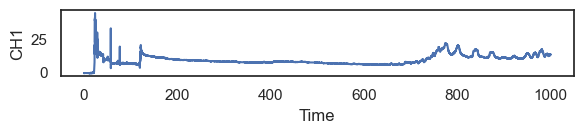

Subset load time: 0.307 s


In [ ]:
from sparcfuse.sparc_fuse_core import open_zarr_from_s3
import time
import matplotlib.pyplot as plt

# Open dataset lazily from S3
ds = open_zarr_from_s3(bucket="sparc-fuse-demo-ab-2025", zarr_path="20_1021_std_xarray.zarr")
print(ds)  # Immediately available metadata, lazy data loading

# Example: load a subset of channel 1 for the first 100,000 timepoints
start = time.perf_counter()
subset_ch1 = ds["signals"].sel(channel=1).isel(time=slice(0, 100000)).load()
elapsed = time.perf_counter() - start

# plot
plt.figure(figsize=(6, 1.5)), plt.plot(subset_ch1.time.values, subset_ch1.values)
plt.xlabel("Time"), plt.ylabel("CH1"), plt.tight_layout(), plt.show()
print(f"Subset load time: {elapsed:.3f} s")

In [89]:
z = open_zarr_from_s3(BUCKET, XARRAY_ZARR, region="eu-north-1")
metadata = dict(z.attrs)
print(json.dumps(metadata['sparc_metadata'], indent=2))

{
  "@context": "http://schema.org/",
  "@id": "https://doi.org/10.26275/qskp-awpu",
  "@type": "Dataset",
  "collections": [
    {
      "name": "Tension files of the colon after optogenetic inhibition of cholinergic or nitrergic myenteric neurons"
    }
  ],
  "contributors": [
    {
      "first_name": "Dante",
      "last_name": "Heredia",
      "orcid": "0000-0002-1019-238X"
    },
    {
      "first_name": "Thomas",
      "last_name": "Gould",
      "orcid": "0000-0003-2154-9388"
    }
  ],
  "creator": {
    "first_name": "Thomas",
    "last_name": "Gould",
    "orcid": "0000-0003-2154-9388"
  },
  "datePublished": "2022-03-24",
  "description": "This dataset examines the effect of optogenetic activation of cholinergic and nitrergic myenteric neurons on motility of the colon, measured by simultaneous tension recordings of the proximal (pC), middle (mC) and distal colon (dC). ",
  "files": [
    {
      "fileType": "BioPAC",
      "name": "20 1021.acq",
      "path": "files/prima

In [20]:
print(subset)


<xarray.DataArray 'signals' (time: 1000)> Size: 8kB
dask.array<getitem, shape=(1000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>
Coordinates:
    channel  int64 8B 0
  * time     (time) float64 8kB 0.0 0.01 0.02 0.03 0.04 ... 9.96 9.97 9.98 9.99


In [ ]:
# Notebook cell: direct comparison of (download+convert from SPARC + local slice) vs (d3/S3 slice)
import time
import shutil
import os
import numpy as np
import xarray as xr
import zarr
import pandas as pd
import s3fs
from sparcfuse.sparc_fuse_core import list_primary_files, download_and_convert_sparc_data

# === CONFIG ===
DATASET_ID = 224
LOCAL_OUTPUT = "../output_single"
RAW_ZARR_NAME = "20_1021_std.zarr"
D3_ZARR_S3 = "s3://sparc-fuse-demo-ab-2025/20_1021_std_xarray.zarr"  # prebuilt self-describing Zarr
REGION = "eu-north-1"
CHANNEL = 0
TIME_SLICE = slice(0, 1000)
REPEATS = 5  # increase if you want tighter statistics

os.environ.setdefault("AWS_DEFAULT_REGION", REGION)
fs = s3fs.S3FileSystem(anon=False, client_kwargs={"region_name": REGION})

def download_convert_and_slice():
    # fresh download+convert, then open local zarr and slice
    if os.path.isdir(LOCAL_OUTPUT):
        shutil.rmtree(LOCAL_OUTPUT)
    start = time.perf_counter()
    files, _ = list_primary_files(DATASET_ID)
    primary_path = files[0]["path"].replace("files/", "")
    download_and_convert_sparc_data(
        DATASET_ID,
        descriptors_dir="../mapping_schemes",
        primary_paths=primary_path,
        output_dir=LOCAL_OUTPUT,
        file_format="zarr"
    )
    # open local zarr
    zarr_path = os.path.join(LOCAL_OUTPUT, RAW_ZARR_NAME)
    try:
        store = zarr.storage.DirectoryStore(zarr_path)
        try:
            root = zarr.open_consolidated(store)
        except Exception:
            root = zarr.open(store)
    except Exception as e:
        raise RuntimeError(f"Failed opening local Zarr: {e}")
    # slice
    signals_arr = root["signals"]
    time_arr = root["time"]
    sig_shape = signals_arr.shape
    tlen = len(time_arr[:])
    if sig_shape[1] == tlen:
        subset = signals_arr[CHANNEL, TIME_SLICE]
    elif sig_shape[0] == tlen:
        subset = signals_arr[TIME_SLICE, CHANNEL]
    else:
        subset = signals_arr[CHANNEL, TIME_SLICE]
    _ = np.array(subset)  # force materialization
    total = time.perf_counter() - start
    return total

def d3_slice_only():
    start = time.perf_counter()
    ds = xr.open_zarr(D3_ZARR_S3, consolidated=True)
    subset = ds["signals"].isel(channel=CHANNEL, time=TIME_SLICE)
    _ = subset.load()
    total = time.perf_counter() - start
    return total

# Warm up
_ = download_convert_and_slice()
_ = d3_slice_only()

# Benchmark
baseline_times = []
d3_times = []
for _ in range(REPEATS):
    baseline_times.append(download_convert_and_slice())
    d3_times.append(d3_slice_only())

# Summary
df = pd.DataFrame({
    "baseline_download+slice_s": baseline_times,
    "d3_slice_s": d3_times,
})
summary = pd.DataFrame({
    "median_s": [df["baseline_download+slice_s"].median(), df["d3_slice_s"].median()],
    "mean_s": [df["baseline_download+slice_s"].mean(), df["d3_slice_s"].mean()],
}, index=["baseline (SPARC download+slice)", "d3 (S3 slice)"])
summary["speedup (baseline / d3)"] = summary.loc["baseline (SPARC download+slice)", "median_s"] / summary.loc["d3 (S3 slice)", "median_s"]

pd.set_option("display.precision", 3)
print(f"Comparison over {REPEATS} runs:") 
display(summary)
print("\nInterpretation: speedup >1 means d3 slice is faster than full SPARC download+slice.")


[WARN] Failed to load descriptor from ./mapping_schemes/mapping_scheme_400_adi.py: No module named 'adi._adi_cffi'
[WARN] Failed to load descriptor from ./mapping_schemes/mapping_scheme_378.py: No module named 'adi._adi_cffi'
[INFO] Loaded 32 descriptor(s) from ./mapping_schemes


Dataset 224: 100%|██████████| 1/1 [00:09<00:00,  9.43s/it]


[WARN] Failed to load descriptor from ./mapping_schemes/mapping_scheme_400_adi.py: No module named 'adi._adi_cffi'
[WARN] Failed to load descriptor from ./mapping_schemes/mapping_scheme_378.py: No module named 'adi._adi_cffi'
[INFO] Loaded 32 descriptor(s) from ./mapping_schemes


Dataset 224: 100%|██████████| 1/1 [00:08<00:00,  8.38s/it]


[WARN] Failed to load descriptor from ./mapping_schemes/mapping_scheme_400_adi.py: No module named 'adi._adi_cffi'
[WARN] Failed to load descriptor from ./mapping_schemes/mapping_scheme_378.py: No module named 'adi._adi_cffi'
[INFO] Loaded 32 descriptor(s) from ./mapping_schemes


Dataset 224: 100%|██████████| 1/1 [00:06<00:00,  6.69s/it]


[WARN] Failed to load descriptor from ./mapping_schemes/mapping_scheme_400_adi.py: No module named 'adi._adi_cffi'
[WARN] Failed to load descriptor from ./mapping_schemes/mapping_scheme_378.py: No module named 'adi._adi_cffi'
[INFO] Loaded 32 descriptor(s) from ./mapping_schemes


Dataset 224: 100%|██████████| 1/1 [00:09<00:00,  9.09s/it]


[WARN] Failed to load descriptor from ./mapping_schemes/mapping_scheme_400_adi.py: No module named 'adi._adi_cffi'
[WARN] Failed to load descriptor from ./mapping_schemes/mapping_scheme_378.py: No module named 'adi._adi_cffi'
[INFO] Loaded 32 descriptor(s) from ./mapping_schemes


Dataset 224: 100%|██████████| 1/1 [00:08<00:00,  8.48s/it]


[WARN] Failed to load descriptor from ./mapping_schemes/mapping_scheme_400_adi.py: No module named 'adi._adi_cffi'
[WARN] Failed to load descriptor from ./mapping_schemes/mapping_scheme_378.py: No module named 'adi._adi_cffi'
[INFO] Loaded 32 descriptor(s) from ./mapping_schemes


Dataset 224: 100%|██████████| 1/1 [00:07<00:00,  7.90s/it]


Comparison over 5 runs:


,median_s,mean_s,speedup (baseline / d3)
baseline (SPARC download+slice),9.762,9.455,13.2
d3 (S3 slice),0.740,0.857,13.2



Interpretation: speedup >1 means d3 slice is faster than full SPARC download+slice.


/var/folders/34/5y88z7rd5ml0ycwmy2g3ntrw0000gn/T/ipykernel_59051/829854985.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary.reset_index(), x="index", y="median_s", palette="plasma")


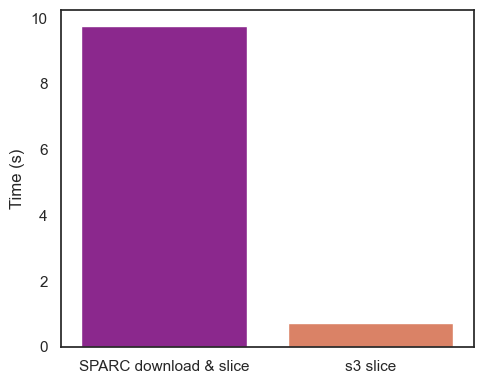

In [ ]:
# plot summary as bar chart
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
# plot with figsize 12x4
plt.figure(figsize=(5, 4))
sns.barplot(data=summary.reset_index(), x="index", y="median_s", palette="plasma")
plt.ylabel("Time (s)")
# x ticks should be SPARC download & slice and s3 slice
plt.xticks(ticks=[0, 1], labels=["SPARC download & slice", "s3 slice"])
plt.xlabel("")
plt.grid(False)
plt.savefig("../stats_figures/performance_comparison.png", dpi=300)
plt.tight_layout()
plt.show()
